# Policy gradients

## Policy learning

**Limitaciones de DQN:** Las Deep Q Networks (y Q-Learning) tienen dos limitaciones importantes:

- Espacio de acción discreto (y espacio de estados discreto)
- Requieren heurísticas para que haya exploración 

Estos métodos se basan en estimar la función **Q** y uego se usa una política determinista de máximas utilidades

$$
\pi(s) = \text{arg}\max_a' Q(s, a')
$$

Una alternativa a lo anterior es aprender directamente la *policy*. Veremos como esto puede resolver las limitaciones antes mencionadas.

En lugar de aprender **Q** podemos aprender directamente

$$
a \sim \pi_\theta (A|S=s)
$$

- La política es estocástica, es decir sigue una distribución de probabilidad
- La acción se muestrea de la política: Esto nos da exploración

Podemos usar una red neuronal para modelar los parámetros de la distribución.

**Ejemplo: Espacio de acción discreto**

Para un espacio de acción discreto con 3 opciones podemos asumir una política con **distribución categórica**.

En este caso se utilizaría una red neuronal con tres salidas correspondientes a $p(a_1|s)$, $p(a_2|s)$  y $p(a_3|s)$, donde cada una está en el rango $[0,1]$  y además suman uno (función de activación de salida softmax).

Luego muestreamos de la distribución categórica usando los parámetros entregados por la red

In [1]:
import numpy as np
from scipy.stats import multinomial
from collections import Counter

neural_net_output = np.array([0.7, 0.1, 0.2])
samples = multinomial(n=1, p=neural_net_output).rvs(10000).argmax(axis=1)

Counter(samples)

Counter({0: 7111, 2: 1904, 1: 985})

**Ejemplo: Espacio de acción continuo**

Para un espacio de acción con dos acciones continuas podemos asumiar una política con distribución Gaussiana.

Usamos una red neuronal con cuatro salidas (dos por acción) correspondientes a $\mu(a_1|s)$, $\log \sigma(a_1|s)$, $\mu(a_2|s)$ y $\log \sigma(a_2|s)$, donde cada una está en el rango de los reales (función de activación de salida identidad).

Luego muestreamos de la distribución Gaussiana usando los parámetros entregados por la red

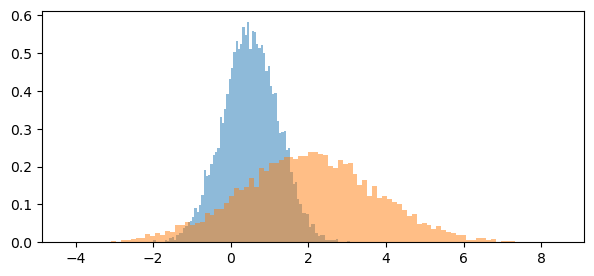

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multinomial
from scipy.stats import multivariate_normal

neural_net_output = np.array([0.5, 2., np.log(0.5), np.log(3.)])

samples = multivariate_normal(mean=neural_net_output[:2], 
                              cov=np.diag(np.exp(neural_net_output[2:]))).rvs(10000)

fig, ax = plt.subplots(figsize=(7, 3))
ax.hist(samples[:, 0], bins=100, alpha=0.5, density=True);
ax.hist(samples[:, 1], bins=100, alpha=0.5, density=True);

## Algoritmo de entrenamiento

El algoritmo que usaremos para entrenar busca lo siguiente:

- Ejecutar la política hasta el término del episodio, grabando las tuplas de acción/estado/recompensa
- Disminuir la probabilidad de las acciones que terminaron en recompensa baja
- Aumentar la probabilidad de las acciones que terminaron en recompensa alta

Esto se puede resumir con la siguiente loss:

$$
\mathcal{L}(s_t, a_t, r_t, \mathcal{H}) = - \log P(a_t|s_t) G_t
$$

donde:

- Log verosimilitud $\log P(a_t|s_t)$: mide que tan posible es haber seleccionado $a_t$
- Ganancia total descontada $G_t$: La ganacia recibida por seleccionar $a_t$

Si entrenamos usando gradiente descendente entonces:

$$
\theta \leftarrow \theta + \eta \nabla \log P(a_t|s_t) G_t
$$

De donde sale el nombre de este algoritmo: *policy gradient*

Veamos un ejemplo en acción. Primero implementarmos una red neuronal simple y una memoría para los episodios: 

In [3]:
import torch

# Modelo para los parámetros de la política
class MultilayerPerceptron(torch.nn.Module):    
    def __init__(self, n_input, n_output, n_hidden=10):
        super(type(self), self).__init__()
        self.linear1 = torch.nn.Linear(n_input, n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, n_hidden)
        self.linear3 = torch.nn.Linear(n_hidden, n_output)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.linear1(x))
        h = self.activation(self.linear2(h))
        return  self.linear3(h)
    
# Memoría para guardar lo que ocurre en un episodio
class Memory:
    def __init__(self): 
        self.reset()
    
    def reset(self): 
        self.s = []
        self.a = []
        self.r = []

    def push(self, s, a, r): 
        self.s.append(s)
        self.a.append(a)
        self.r.append(r)

In [4]:
import gymnasium as gym
from tqdm.notebook import tqdm

env = gym.make("CartPole-v1")
n_state = env.observation_space.shape[0] # Número de estados
n_action = env.action_space.n # Número de acciones
gamma = 0.999

torch.manual_seed(1234)
np.random.seed(1234)
model = MultilayerPerceptron(n_state, n_action)
loglikelihood = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

memory = Memory()

num_episodes = 3000
diagnostics = {'Rewards': np.zeros(shape=(num_episodes,)), 
               'Loss': np.zeros(shape=(num_episodes,))
               }

for episode in tqdm(range(num_episodes)):
    state, _ = env.reset()
    terminated, truncated = False, False
    
    while not terminated and not truncated:       
        # Escoger acción
        state = torch.tensor(state).float()  
        with torch.no_grad():
            logits = model.forward(state)
            probs = torch.nn.Softmax(dim=0)(logits).numpy()
        a = np.random.choice(n_action, size=1, p=probs)[0]
        s, r, terminated, truncated, info = env.step(a)
        # Guardar en memoria
        memory.push(state, torch.tensor(a, dtype=int), torch.tensor(r))
        # Preparar para próximo paso
        diagnostics['Rewards'][episode] += r
        state = s
    # Una vez completado el episodio actualizamos el modelo
    # Primero calculamos la recompensa total descontada
    Gt = (torch.stack(memory.r)*gamma**torch.arange(0, len(memory.r)).float()).flip(0).cumsum(0).flip(0)
    # Luego la normalizamos (mejora la estabilidad del entrenamiento)
    Gt = (Gt - Gt.mean())/Gt.std()
    # Predicción (sin normalizar) de la probabilidad de acción
    logits = model.forward(torch.stack(memory.s))
    # Cálculo de la loss
    loss = torch.sum(loglikelihood(logits, torch.stack(memory.a))*Gt)
    # Calculamos los gradientes y actualizamos los parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()     
    diagnostics['Loss'][episode] += loss
    # Borramos la memoria
    memory.reset() 

  0%|          | 0/3000 [00:00<?, ?it/s]

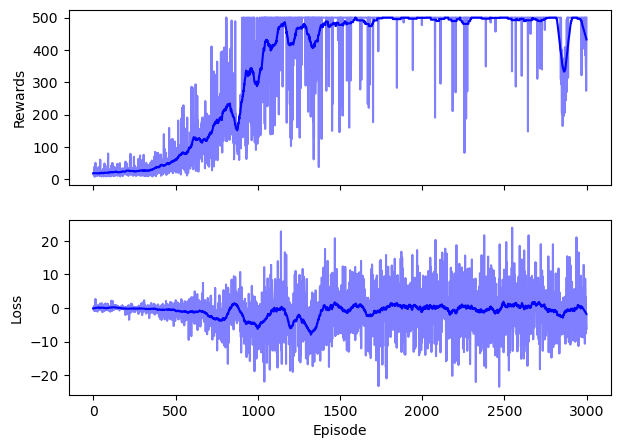

In [5]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for ax_, (key, val) in zip(ax, diagnostics.items()):
    ax_.plot(val, alpha=0.5, c='b')
    ax_.plot(savgol_filter(val, 50, 1), c='b')
    ax_.set_ylabel(key)
ax_.set_xlabel('Episode');

El siguiente bloque muestra el agente desarrollando la tarea según la política aprendida en una nueva ventana.

In [6]:
env = gym.make("CartPole-v1", render_mode="human")
env.reset()

for k in range(500):
    env.render()
    state = torch.from_numpy(np.array(env.state).astype('float32'))
    with torch.no_grad():
        logits = model.forward(state)
        probs = torch.nn.Softmax(dim=0)(logits).numpy()
    a = np.random.choice(2, size=1, p=probs)[0]
    s, r, terminated, truncated, info = env.step(a)
    if terminated or truncated:
        break
print(k)
env.close()

error: wayland not available

## AlphaGo 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/FloorGoban.JPG/619px-FloorGoban.JPG" width="300">

El [Go](https://en.wikipedia.org/wiki/Go_%28game%29) es un juego de mesa de origen chino con un tablero de 19x19 espacios donde dos jugadores compiten por cubrir la mayor área en el tablero. El espacio de estados tiene [más movimientos legales que átomos en el universe](https://en.wikipedia.org/wiki/Go_and_mathematics#Legal_positions).

El equipo de DeepMind ha utilizado Go como benchmark para proponer nuevos modelos de RL profundo. El primero de ellos es [Alpha Go](https://www.deepmind.com/research/highlighted-research/alphago) (2016) el cual combina bastantes técnicas:

1. Se entrena una red neuronal supervisada con movimientos de humanos expertos: Imitar a los humanos
1. Se entrena un agente basado en política que compite contra el modelo entrenado: Aprender nuevos movimientos
1. Una vez que el agente supera al modelo supervisado se sigue entrenando contra si mismo
1. Adicionalmente se ocupa un modelo basado en valor para evaluar los movimientos del agente

:::{seealso}

- [Presentación autocontenida sobre Alpha Go](https://www.slideshare.net/ckmarkohchang/alphago-in-depth)
- Modelo [Alpha Go Zero](https://www.deepmind.com/blog/alphago-zero-starting-from-scratch) que no usa pre-entrenamiento con redes supervisadas. En su lugar juego contra si mismo partiendo desde un comportamiento aleatorio.

:::



## Desafíos de Aprendizaje Reforzado

Para entrenar con *policy gradient* necesitamos correr el agente hasta el término del episodio. Sin embargo en muchas situaciones esto significa la muerte del agente ¿Cómo podemos desarrollar un agente en el mundo real?

Una alternativa es usar simuladores:

- Usar un simulación realista del ambiente para entrenar, e.g. [VISTA](https://vista.csail.mit.edu/)
- Hacer transferencia de aprendizaje desde el simulador al mundo real (por las imperfecciones del simulador)

Otra alternativa es one-shot learning: [One-shot learning of manipulation skills with online dynamics adaptation and neural network priors](http://rll.berkeley.edu/iros2016onlinecontrol/online_control.pdf)

Y otra alternativa más es usar apoyo humano: [Trial without Error: Towards Safe Reinforcement Learning via Human Intervention](https://arxiv.org/abs/1707.05173) y [blog post](https://owainevans.github.io/blog/hirl_blog.html)

Otro desafío general de RL es el proponer buenas funciones de recompensa. Este y otros desafíos abiertos se discuten en esta [fuerte crítica a RL](https://www.alexirpan.com/2018/02/14/rl-hard.html)